# 🔬 Wafer Defect Detection - Complete Project
## Using LSWMD.pkl Dataset

**Project Overview:**
- Load wafer defect data from LSWMD.pkl
- Build CNN classifier to detect defect patterns
- Train and evaluate the model
- Perfect for portfolio (Nova, Applied Materials, etc.)

**Dataset:** WM-811K (LSWMD.pkl format)

---

### 📋 Instructions:
1. Update `PICKLE_PATH` in Cell 2 with your LSWMD.pkl file location
2. Run all cells in order (Shift+Enter)
3. Wait for training to complete
4. Review results and visualizations

---

## 📚 Step 1: Import All Required Libraries

In [13]:
# Data manipulation and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import pickle
import os

# Deep Learning - TensorFlow/Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical

# Machine Learning utilities
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Configure plot style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✅ All libraries imported successfully!")
print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {len(tf.config.list_physical_devices('GPU')) > 0}")
print(f"GPU Devices: {tf.config.list_physical_devices('GPU')}")

✅ All libraries imported successfully!
TensorFlow version: 2.20.0
GPU Available: False
GPU Devices: []


## 📦 Step 2: Load LSWMD.pkl Dataset

⚠️ **IMPORTANT:** Update the `PICKLE_PATH` variable below with the actual path to your LSWMD.pkl file!

In [14]:
# ⚠️⚠️⚠️ UPDATE THIS PATH! ⚠️⚠️⚠️
PICKLE_PATH = "/Users/avicii/Documents/python/projects/wafer/LSWMD.pkl"

print("="*70)
print("LOADING LSWMD.pkl DATASET")
print("="*70)

# Load pickle file with compatibility fix
print(f"\n📂 Loading data from: {PICKLE_PATH}")

try:
    # Fix for pandas compatibility issue
    import sys
    import pandas.core.indexes as indexes
    sys.modules['pandas.indexes'] = indexes
    
    with open(PICKLE_PATH, 'rb') as f:
        raw_data = pickle.load(f, encoding='latin1')
    
    print(f"✅ Data loaded successfully!")
    print(f"   Total wafers in dataset: {len(raw_data):,}")
    print(f"   Data type: {type(raw_data)}")
    
    # Check if it's a DataFrame
    if isinstance(raw_data, pd.DataFrame):
        print(f"\n📊 DataFrame structure:")
        print(f"   Columns: {list(raw_data.columns)}")
        print(f"   Shape: {raw_data.shape}")
        
        # Show first row
        first_wafer = raw_data.iloc[0]
        print(f"\n   First wafer sample:")
        print(f"   - Wafer Map Shape: {first_wafer['waferMap'].shape if 'waferMap' in raw_data.columns else 'N/A'}")
        print(f"   - Failure Type: {first_wafer.get('failureType', 'N/A')}")
    else:
        # If it's a list or dict
        first_wafer = raw_data[0] if isinstance(raw_data, list) else list(raw_data.values())[0]
        print(f"\n📊 First wafer information:")
        print(f"   Keys: {list(first_wafer.keys())}")
        print(f"   Wafer Map Shape: {first_wafer['waferMap'].shape}")
        print(f"   Failure Type: {first_wafer['failureType']}")
    
except FileNotFoundError:
    print(f"❌ ERROR: File not found at {PICKLE_PATH}")
    raise
except Exception as e:
    print(f"❌ ERROR loading file: {e}")
    import traceback
    traceback.print_exc()
    raise

LOADING LSWMD.pkl DATASET

📂 Loading data from: /Users/avicii/Documents/python/projects/wafer/LSWMD.pkl
✅ Data loaded successfully!
   Total wafers in dataset: 811,457
   Data type: <class 'pandas.core.frame.DataFrame'>

📊 DataFrame structure:
   Columns: ['waferMap', 'dieSize', 'lotName', 'waferIndex', 'trianTestLabel', 'failureType']
   Shape: (811457, 6)

   First wafer sample:
   - Wafer Map Shape: (45, 48)
   - Failure Type: [['none']]


## 🔍 Step 3: Extract and Analyze Wafer Data

In [15]:
print("="*70)
print("EXTRACTING WAFER MAPS AND LABELS")
print("="*70)

# Check data type and extract accordingly
if isinstance(raw_data, pd.DataFrame):
    print(f"\n📊 Working with DataFrame structure")
    
    # Extract data from DataFrame
    wafer_maps_raw = []
    labels_raw = []
    metadata = []
    
    for idx, row in raw_data.iterrows():
        failure_type = row.get('failureType', None)
        
        # Handle different types of failure_type
        if failure_type is None:
            continue
        
        # Check if it's an array or single value
        if isinstance(failure_type, np.ndarray):
            if failure_type.size == 0:
                continue
            failure_type = failure_type.item() if failure_type.size == 1 else str(failure_type)
        
        # Skip if it's NaN or empty
        try:
            if pd.isna(failure_type):
                continue
        except (ValueError, TypeError):
            pass
        
        wafer_maps_raw.append(row['waferMap'])
        labels_raw.append(failure_type)
        metadata.append({
            'index': idx,
            'failure_type': failure_type,
            'train_test': row.get('trianTestLabel', 'Unknown'),
            'lot_name': row.get('lotName', 'Unknown')
        })
        
        # Progress indicator
        if (len(wafer_maps_raw) % 50000) == 0:
            print(f"   Processed {len(wafer_maps_raw):,} valid wafers...")
else:
    # Original code for list/dict structure
    wafer_maps_raw = []
    labels_raw = []
    metadata = []
    
    for idx, wafer in enumerate(raw_data):
        failure_type = wafer.get('failureType', None)
        
        if failure_type is None:
            continue
        
        wafer_maps_raw.append(wafer['waferMap'])
        labels_raw.append(failure_type)
        metadata.append({
            'index': idx,
            'failure_type': failure_type,
            'train_test': wafer.get('trianTestLabel', 'Unknown'),
            'lot_name': wafer.get('lotName', 'Unknown')
        })

# Convert to numpy arrays
wafer_maps_raw = np.array(wafer_maps_raw, dtype=object)
labels_raw = np.array(labels_raw)

print(f"\n✅ Extracted {len(wafer_maps_raw):,} valid wafers")

# Analyze label distribution
print(f"\n📊 FAILURE TYPE DISTRIBUTION:")
print("="*70)
label_counts = Counter(labels_raw)
for label, count in sorted(label_counts.items(), key=lambda x: x[1], reverse=True):
    percentage = (count / len(labels_raw)) * 100
    bar = "█" * int(percentage / 2)
    print(f"{label:15s}: {bar:30s} {count:5,} ({percentage:5.2f}%)")

print(f"\nTotal unique defect types: {len(label_counts)}")

EXTRACTING WAFER MAPS AND LABELS

📊 Working with DataFrame structure
   Processed 50,000 valid wafers...
   Processed 100,000 valid wafers...
   Processed 150,000 valid wafers...

✅ Extracted 172,950 valid wafers

📊 FAILURE TYPE DISTRIBUTION:
none           : ██████████████████████████████████████████ 147,431 (85.24%)
Edge-Ring      : ██                             9,680 ( 5.60%)
Edge-Loc       : █                              5,189 ( 3.00%)
Center         : █                              4,294 ( 2.48%)
Loc            : █                              3,593 ( 2.08%)
Scratch        :                                1,193 ( 0.69%)
Random         :                                  866 ( 0.50%)
Donut          :                                  555 ( 0.32%)
Near-full      :                                  149 ( 0.09%)

Total unique defect types: 9


## 📊 Step 4: Visualize Sample Wafer Maps

🎨 Visualizing sample wafer maps...



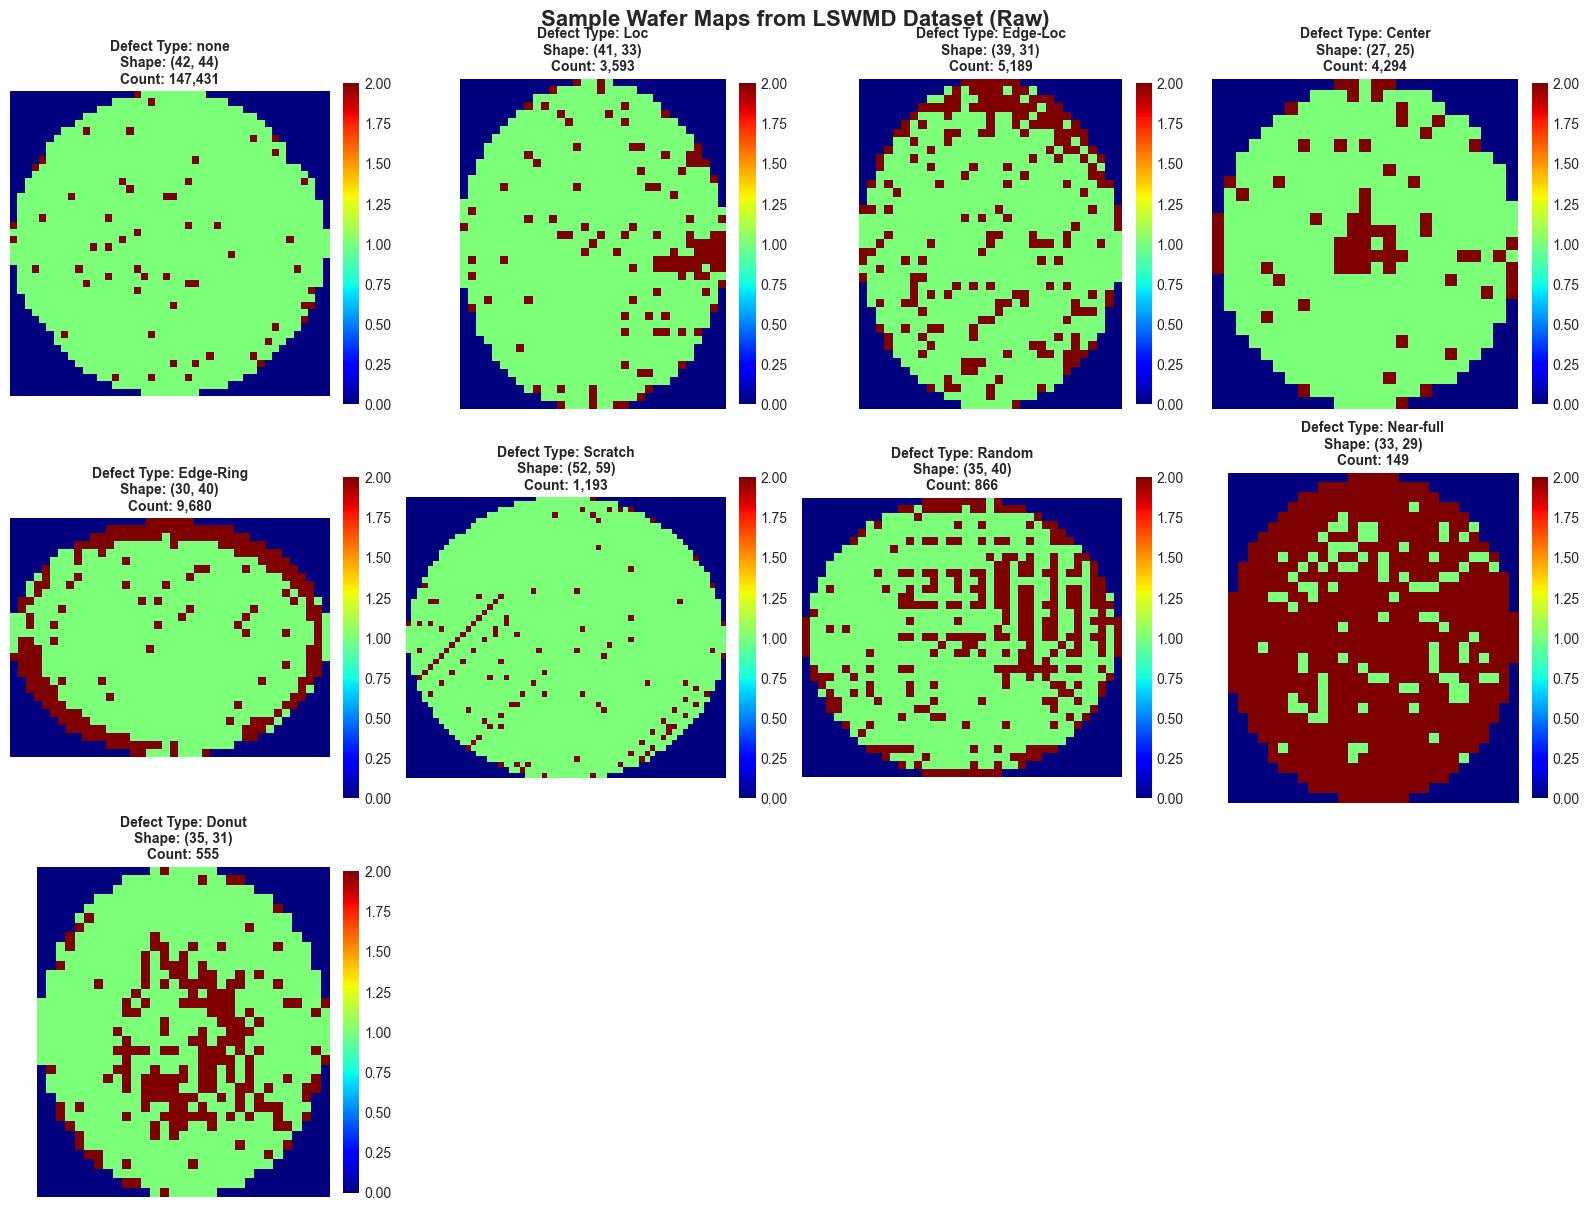

✅ Visualization complete!


In [16]:
print("🎨 Visualizing sample wafer maps...\n")

# Get unique labels
unique_labels = list(label_counts.keys())
n_samples = min(12, len(unique_labels))

# Create figure
fig, axes = plt.subplots(3, 4, figsize=(16, 12))
axes = axes.ravel()

for i, label in enumerate(unique_labels[:n_samples]):
    # Find wafers with this label
    label_indices = np.where(labels_raw == label)[0]
    
    if len(label_indices) == 0:
        continue
    
    # Pick random wafer
    idx = np.random.choice(label_indices)
    wafer_map = wafer_maps_raw[idx]
    
    # Plot
    im = axes[i].imshow(wafer_map, cmap='jet', interpolation='nearest')
    axes[i].set_title(f'Defect Type: {label}\nShape: {wafer_map.shape}\nCount: {label_counts[label]:,}', 
                     fontsize=10, fontweight='bold')
    axes[i].axis('off')
    plt.colorbar(im, ax=axes[i], fraction=0.046, pad=0.04)

# Hide unused subplots
for i in range(n_samples, 12):
    axes[i].axis('off')

plt.tight_layout()
plt.suptitle('Sample Wafer Maps from LSWMD Dataset (Raw)', fontsize=16, y=1.002, fontweight='bold')
plt.show()

print("✅ Visualization complete!")

## 🔧 Step 5: Normalize Wafer Sizes

Different wafers have different sizes. We'll normalize them all to the same size for CNN training.

In [17]:
# Target size for normalization
TARGET_SIZE = (96, 96)  # You can change this: (64, 64) or (128, 128)

print("="*70)
print(f"NORMALIZING WAFER MAPS TO {TARGET_SIZE}")
print("="*70)

def pad_wafer_to_size(wafer_map, target_size):
    """
    Pad wafer map to target size (center the wafer)
    """
    h, w = wafer_map.shape
    target_h, target_w = target_size
    
    # Create padded array filled with zeros
    padded = np.zeros(target_size, dtype=wafer_map.dtype)
    
    # Calculate padding to center the wafer
    pad_h = (target_h - h) // 2
    pad_w = (target_w - w) // 2
    
    # Ensure we don't exceed boundaries
    h_start = max(0, pad_h)
    w_start = max(0, pad_w)
    h_end = min(target_h, pad_h + h)
    w_end = min(target_w, pad_w + w)
    
    # Calculate source dimensions
    source_h = h_end - h_start
    source_w = w_end - w_start
    
    # Copy data to padded array
    padded[h_start:h_end, w_start:w_end] = wafer_map[:source_h, :source_w]
    
    return padded

# Normalize all wafers
print(f"\n🔄 Processing {len(wafer_maps_raw):,} wafer maps...")

wafer_maps_normalized = []
for i, wafer_map in enumerate(wafer_maps_raw):
    normalized = pad_wafer_to_size(wafer_map, TARGET_SIZE)
    wafer_maps_normalized.append(normalized)
    
    # Progress indicator
    if (i + 1) % 5000 == 0:
        print(f"   Processed {i+1:,}/{len(wafer_maps_raw):,} wafers...")

wafer_maps_normalized = np.array(wafer_maps_normalized)

print(f"\n✅ Normalization complete!")
print(f"   Normalized shape: {wafer_maps_normalized.shape}")
print(f"   Min value: {wafer_maps_normalized.min():.2f}")
print(f"   Max value: {wafer_maps_normalized.max():.2f}")

NORMALIZING WAFER MAPS TO (96, 96)

🔄 Processing 172,950 wafer maps...
   Processed 5,000/172,950 wafers...
   Processed 10,000/172,950 wafers...
   Processed 15,000/172,950 wafers...
   Processed 20,000/172,950 wafers...
   Processed 25,000/172,950 wafers...
   Processed 30,000/172,950 wafers...
   Processed 35,000/172,950 wafers...
   Processed 40,000/172,950 wafers...
   Processed 45,000/172,950 wafers...
   Processed 50,000/172,950 wafers...
   Processed 55,000/172,950 wafers...
   Processed 60,000/172,950 wafers...
   Processed 65,000/172,950 wafers...
   Processed 70,000/172,950 wafers...
   Processed 75,000/172,950 wafers...
   Processed 80,000/172,950 wafers...
   Processed 85,000/172,950 wafers...
   Processed 90,000/172,950 wafers...
   Processed 95,000/172,950 wafers...
   Processed 100,000/172,950 wafers...
   Processed 105,000/172,950 wafers...
   Processed 110,000/172,950 wafers...
   Processed 115,000/172,950 wafers...
   Processed 120,000/172,950 wafers...
   Processed 

## 🎯 Step 6: Prepare Data for CNN Training

In [18]:
print("="*70)
print("PREPARING DATA FOR CNN TRAINING")
print("="*70)

# Add channel dimension for CNN (grayscale images)
X = wafer_maps_normalized.reshape(-1, TARGET_SIZE[0], TARGET_SIZE[1], 1)
print(f"\n📐 Added channel dimension: {X.shape}")

# Normalize pixel values to [0, 1]
X = X.astype('float32')
X_min = X.min()
X_max = X.max()

if X_max > X_min:
    X = (X - X_min) / (X_max - X_min)
    print(f"✅ Normalized pixel values to [0, 1]")
else:
    print(f"⚠️ Warning: All pixel values are the same")

# Encode labels to integers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(labels_raw)

print(f"\n🏷️ Label encoding:")
for i, label in enumerate(label_encoder.classes_):
    count = np.sum(y_encoded == i)
    print(f"   {i}: {label:15s} -> {count:5,} samples")

# Convert to categorical (one-hot encoding)
y_categorical = to_categorical(y_encoded)

print(f"\n✅ DATA PREPARATION COMPLETE!")
print("="*70)
print(f"Final dataset shape:")
print(f"   X (images): {X.shape}")
print(f"   y (labels): {y_categorical.shape}")
print(f"   Number of classes: {len(label_encoder.classes_)}")
print(f"   Image size: {TARGET_SIZE[0]}x{TARGET_SIZE[1]}")
print(f"   Total samples: {len(X):,}")

PREPARING DATA FOR CNN TRAINING

📐 Added channel dimension: (172950, 96, 96, 1)
✅ Normalized pixel values to [0, 1]

🏷️ Label encoding:
   0: Center          -> 4,294 samples
   1: Donut           ->   555 samples
   2: Edge-Loc        -> 5,189 samples
   3: Edge-Ring       -> 9,680 samples
   4: Loc             -> 3,593 samples
   5: Near-full       ->   149 samples
   6: Random          ->   866 samples
   7: Scratch         -> 1,193 samples
   8: none            -> 147,431 samples

✅ DATA PREPARATION COMPLETE!
Final dataset shape:
   X (images): (172950, 96, 96, 1)
   y (labels): (172950, 9)
   Number of classes: 9
   Image size: 96x96
   Total samples: 172,950


## 👁️ Step 7: Visualize Normalized Wafers

🎨 Visualizing normalized wafer maps...



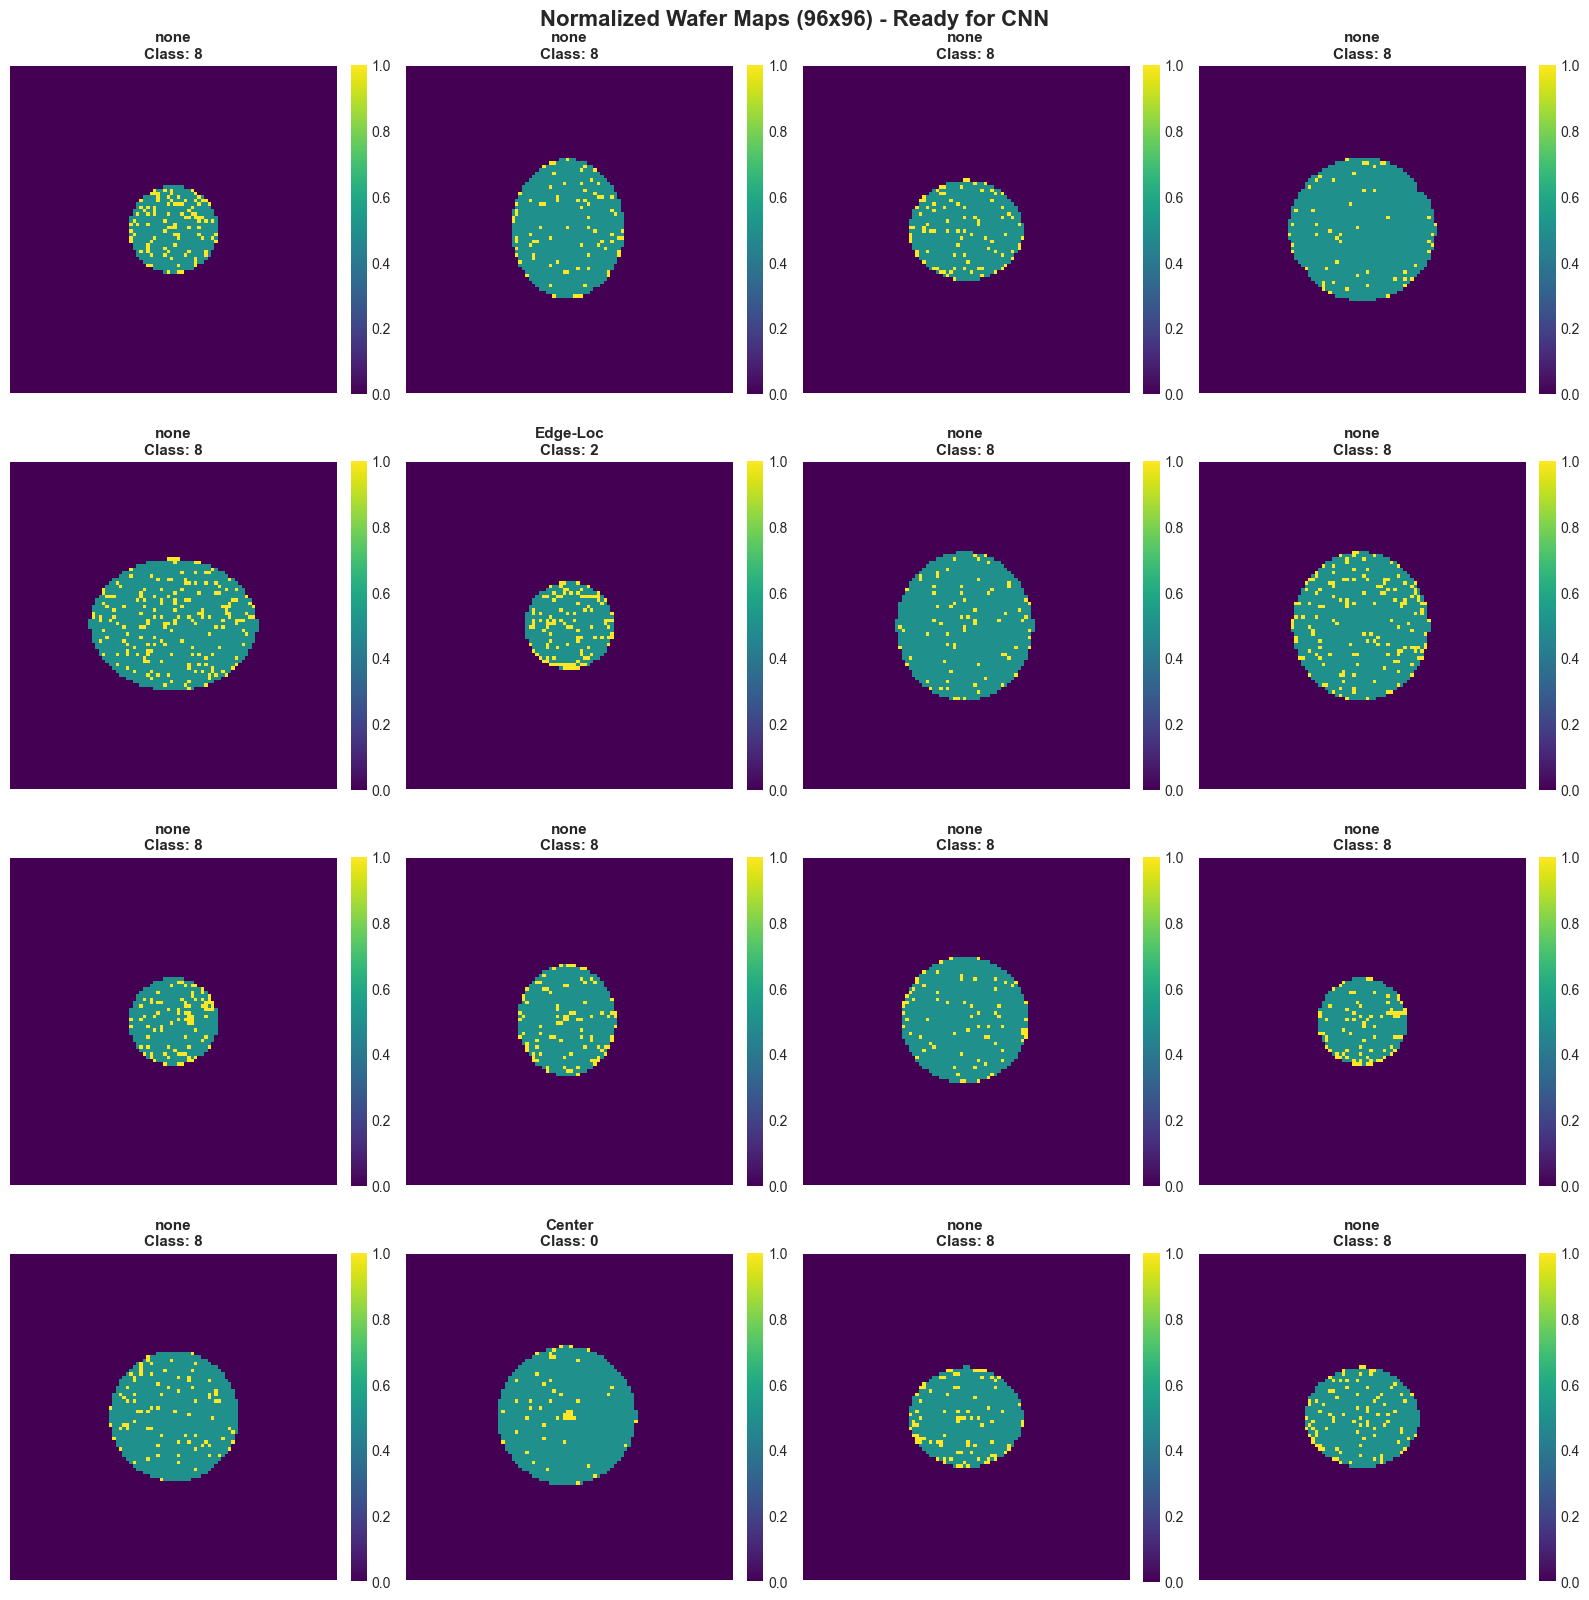

✅ Visualization complete!


In [19]:
print("🎨 Visualizing normalized wafer maps...\n")

# Create figure
fig, axes = plt.subplots(4, 4, figsize=(16, 16))
axes = axes.ravel()

# Random samples
n_samples = 16
indices = np.random.choice(len(X), n_samples, replace=False)

for i, idx in enumerate(indices):
    # Get image and label
    img = X[idx].squeeze()  # Remove channel dimension for display
    label_idx = np.argmax(y_categorical[idx])
    label_name = label_encoder.classes_[label_idx]
    
    # Plot
    im = axes[i].imshow(img, cmap='viridis', interpolation='nearest')
    axes[i].set_title(f'{label_name}\nClass: {label_idx}', fontsize=11, fontweight='bold')
    axes[i].axis('off')
    plt.colorbar(im, ax=axes[i], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.suptitle(f'Normalized Wafer Maps ({TARGET_SIZE[0]}x{TARGET_SIZE[1]}) - Ready for CNN', 
             fontsize=16, y=1.001, fontweight='bold')
plt.show()

print("✅ Visualization complete!")

## 🔀 Step 8: Train/Validation/Test Split

In [20]:
print("="*70)
print("SPLITTING DATASET")
print("="*70)

# Split: 70% train, 15% validation, 15% test
print("\n📊 Split ratio: 70% Train / 15% Val / 15% Test\n")

# First split: separate test set (15%)
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y_categorical, 
    test_size=0.15, 
    random_state=42, 
    stratify=y_encoded
)

# Second split: separate validation from training (15% of remaining 85% ≈ 17.6%)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, 
    test_size=0.176,  # 15/(100-15) = 0.176
    random_state=42, 
    stratify=np.argmax(y_temp, axis=1)
)

# Print split information
print("✅ Dataset Split Complete!")
print("="*70)
print(f"Training set:   {len(X_train):6,} samples ({len(X_train)/len(X)*100:5.2f}%)")
print(f"Validation set: {len(X_val):6,} samples ({len(X_val)/len(X)*100:5.2f}%)")
print(f"Test set:       {len(X_test):6,} samples ({len(X_test)/len(X)*100:5.2f}%)")
print(f"Total:          {len(X):6,} samples")

# Verify class distribution in splits
print("\n📊 Class distribution in splits:")
train_classes = np.argmax(y_train, axis=1)
val_classes = np.argmax(y_val, axis=1)
test_classes = np.argmax(y_test, axis=1)

for i, label in enumerate(label_encoder.classes_):
    train_count = np.sum(train_classes == i)
    val_count = np.sum(val_classes == i)
    test_count = np.sum(test_classes == i)
    print(f"   Class {i} ({label:15s}): Train={train_count:4,} | Val={val_count:4,} | Test={test_count:4,}")

# Update global variables
NUM_CLASSES = len(label_encoder.classes_)
IMG_SIZE = TARGET_SIZE

print(f"\n✅ Ready for model training!")
print(f"   Image size: {IMG_SIZE}")
print(f"   Number of classes: {NUM_CLASSES}")

SPLITTING DATASET

📊 Split ratio: 70% Train / 15% Val / 15% Test

✅ Dataset Split Complete!
Training set:   121,133 samples (70.04%)
Validation set: 25,874 samples (14.96%)
Test set:       25,943 samples (15.00%)
Total:          172,950 samples

📊 Class distribution in splits:
   Class 0 (Center         ): Train=3,008 | Val= 642 | Test= 644
   Class 1 (Donut          ): Train= 389 | Val=  83 | Test=  83
   Class 2 (Edge-Loc       ): Train=3,634 | Val= 776 | Test= 779
   Class 3 (Edge-Ring      ): Train=6,780 | Val=1,448 | Test=1,452
   Class 4 (Loc            ): Train=2,516 | Val= 538 | Test= 539
   Class 5 (Near-full      ): Train= 105 | Val=  22 | Test=  22
   Class 6 (Random         ): Train= 606 | Val= 130 | Test= 130
   Class 7 (Scratch        ): Train= 835 | Val= 179 | Test= 179
   Class 8 (none           ): Train=103,260 | Val=22,056 | Test=22,115

✅ Ready for model training!
   Image size: (96, 96)
   Number of classes: 9


## 🏗️ Step 9: Build CNN Model

In [21]:
print("="*70)
print("BUILDING CNN MODEL")
print("="*70)

def create_wafer_cnn(input_shape, num_classes):
    """
    Create CNN model for wafer defect classification
    
    Architecture:
    - 4 Convolutional blocks with BatchNorm and Dropout
    - Global Average Pooling
    - Dense layers with regularization
    """
    model = models.Sequential([
        # Block 1
        layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Block 2
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Block 3
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Block 4
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Dense layers
        layers.GlobalAveragePooling2D(),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ], name='Wafer_CNN')
    
    return model

# Create model
input_shape = (IMG_SIZE[0], IMG_SIZE[1], 1)
model = create_wafer_cnn(input_shape, NUM_CLASSES)

print("\n✅ Model created successfully!\n")
model.summary()

# Calculate total parameters
total_params = model.count_params()
print(f"\n📊 Total parameters: {total_params:,}")

BUILDING CNN MODEL

✅ Model created successfully!



Model: "Wafer_CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 96, 96, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 96, 96, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 96, 96, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 96, 96, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 48, 48, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 48, 48, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,443,817 (5.51 MB)

 Trainable params: 1,440,361 (5.49 MB)

 Non-trainable params: 3,456 (13.50 KB)


📊 Total parameters: 1,443,817


## ⚙️ Step 10: Compile Model

In [22]:
print("="*70)
print("COMPILING MODEL")
print("="*70)

# Compile model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        keras.metrics.TopKCategoricalAccuracy(k=3, name='top3_accuracy')
    ]
)

print("\n✅ Model compiled successfully!")
print("\nOptimizer: Adam (lr=0.001)")
print("Loss: Categorical Crossentropy")
print("Metrics: Accuracy, Top-3 Accuracy")

COMPILING MODEL

✅ Model compiled successfully!

Optimizer: Adam (lr=0.001)
Loss: Categorical Crossentropy
Metrics: Accuracy, Top-3 Accuracy


## 🔄 Step 11: Setup Data Augmentation and Callbacks

In [23]:
print("="*70)
print("CONFIGURING TRAINING SETUP")
print("="*70)

# Data augmentation for training
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.1,
    fill_mode='nearest'
)

print("\n✅ Data augmentation configured")
print("   - Random rotation: ±20°")
print("   - Random shifts: ±10%")
print("   - Random flips: horizontal & vertical")
print("   - Random zoom: ±10%")

# Training callbacks
callbacks = [
    # Save best model
    ModelCheckpoint(
        'best_wafer_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    ),
    
    # Early stopping
    EarlyStopping(
        monitor='val_loss',
        patience=20,
        restore_best_weights=True,
        verbose=1
    ),
    
    # Reduce learning rate on plateau
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=7,
        min_lr=1e-7,
        verbose=1
    )
]

print("\n✅ Training callbacks configured")
print("   - ModelCheckpoint: saves best model")
print("   - EarlyStopping: patience=20 epochs")
print("   - ReduceLROnPlateau: reduces LR when stuck")

# Training parameters
BATCH_SIZE = 32
EPOCHS = 100

print(f"\n📊 Training parameters:")
print(f"   Batch size: {BATCH_SIZE}")
print(f"   Max epochs: {EPOCHS}")
print(f"   Steps per epoch: {len(X_train) // BATCH_SIZE}")

CONFIGURING TRAINING SETUP

✅ Data augmentation configured
   - Random rotation: ±20°
   - Random shifts: ±10%
   - Random flips: horizontal & vertical
   - Random zoom: ±10%

✅ Training callbacks configured
   - ModelCheckpoint: saves best model
   - EarlyStopping: patience=20 epochs
   - ReduceLROnPlateau: reduces LR when stuck

📊 Training parameters:
   Batch size: 32
   Max epochs: 100
   Steps per epoch: 3785


## 🚀 Step 12: Train the Model

This will take some time depending on your hardware. With GPU it should be faster.

In [ ]:
print("="*70)
print("STARTING MODEL TRAINING")
print("="*70)
print("\n⏳ This may take a while... Grab a coffee! ☕\n")

# Train model
history = model.fit(
    train_datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)

print("\n" + "="*70)
print("✅ TRAINING COMPLETE!")
print("="*70)

STARTING MODEL TRAINING

⏳ This may take a while... Grab a coffee! ☕

Epoch 1/100
  79/3786 ━━━━━━━━━━━━━━━━━━━━ 33:32 543ms/step - accuracy: 0.4373 - loss: 2.3332 - top3_accuracy: 0.6363

## 📊 Step 13: Visualize Training History

In [ ]:
print("📈 Plotting training history...\n")

# Create figure with subplots
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

# Plot 1: Accuracy
axes[0].plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
axes[0].plot(history.history['val_accuracy'], label='Val Accuracy', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].set_title('Model Accuracy', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Plot 2: Loss
axes[1].plot(history.history['loss'], label='Train Loss', linewidth=2)
axes[1].plot(history.history['val_loss'], label='Val Loss', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Loss', fontsize=12)
axes[1].set_title('Model Loss', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

# Plot 3: Top-3 Accuracy
axes[2].plot(history.history['top3_accuracy'], label='Train Top-3', linewidth=2)
axes[2].plot(history.history['val_top3_accuracy'], label='Val Top-3', linewidth=2)
axes[2].set_xlabel('Epoch', fontsize=12)
axes[2].set_ylabel('Top-3 Accuracy', fontsize=12)
axes[2].set_title('Top-3 Accuracy', fontsize=14, fontweight='bold')
axes[2].legend(fontsize=11)
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print best results
best_val_acc = max(history.history['val_accuracy'])
best_epoch = history.history['val_accuracy'].index(best_val_acc) + 1
best_val_loss = min(history.history['val_loss'])

print("\n" + "="*70)
print("🏆 BEST TRAINING RESULTS")
print("="*70)
print(f"Best Validation Accuracy: {best_val_acc:.4f} at epoch {best_epoch}")
print(f"Best Validation Loss: {best_val_loss:.4f}")
print(f"Final Train Accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"Final Val Accuracy: {history.history['val_accuracy'][-1]:.4f}")

## 🎯 Step 14: Evaluate Model on Test Set

In [ ]:
print("="*70)
print("EVALUATING MODEL ON TEST SET")
print("="*70)

# Evaluate on test set
print("\n🔍 Running predictions on test set...\n")
test_loss, test_acc, test_top3_acc = model.evaluate(X_test, y_test, verbose=1)

# Get predictions
y_pred_proba = model.predict(X_test, verbose=1)
y_pred_classes = np.argmax(y_pred_proba, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Calculate accuracy
test_accuracy = accuracy_score(y_true_classes, y_pred_classes)

print("\n" + "="*70)
print("🎯 TEST SET RESULTS")
print("="*70)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)")
print(f"Test Top-3 Accuracy: {test_top3_acc:.4f} ({test_top3_acc*100:.2f}%)")
print(f"\nCorrect predictions: {np.sum(y_pred_classes == y_true_classes):,} / {len(y_test):,}")

## 📋 Step 15: Classification Report

In [ ]:
print("="*70)
print("CLASSIFICATION REPORT")
print("="*70)

# Generate classification report
report = classification_report(
    y_true_classes, 
    y_pred_classes, 
    target_names=label_encoder.classes_,
    digits=4
)

print("\n" + report)

# Per-class accuracy
print("\n" + "="*70)
print("PER-CLASS ACCURACY")
print("="*70)

for i, label in enumerate(label_encoder.classes_):
    mask = y_true_classes == i
    if np.sum(mask) > 0:
        class_acc = np.sum((y_pred_classes == i) & mask) / np.sum(mask)
        total = np.sum(mask)
        correct = np.sum((y_pred_classes == i) & mask)
        bar = "█" * int(class_acc * 30)
        print(f"{label:15s}: {bar:30s} {class_acc*100:6.2f}% ({correct:3,}/{total:3,})")

## 🔥 Step 16: Confusion Matrix

In [ ]:
print("📊 Generating confusion matrix...\n")

# Calculate confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(14, 12))
sns.heatmap(
    cm, 
    annot=True, 
    fmt='d', 
    cmap='Blues',
    xticklabels=label_encoder.classes_,
    yticklabels=label_encoder.classes_,
    cbar_kws={'label': 'Count'}
)

plt.title('Confusion Matrix - Wafer Defect Classification', fontsize=16, fontweight='bold', pad=20)
plt.ylabel('True Label', fontsize=14)
plt.xlabel('Predicted Label', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

print("✅ Confusion matrix generated!")

## 🔮 Step 17: Visualize Predictions

In [ ]:
print("🎨 Visualizing model predictions...\n")

# Select random samples
n_samples = 16
indices = np.random.choice(len(X_test), n_samples, replace=False)

fig, axes = plt.subplots(4, 4, figsize=(18, 20))
axes = axes.ravel()

for i, idx in enumerate(indices):
    # Get image and labels
    img = X_test[idx].squeeze()
    true_class = y_true_classes[idx]
    pred_class = y_pred_classes[idx]
    confidence = y_pred_proba[idx][pred_class] * 100
    
    # Get class names
    true_label = label_encoder.classes_[true_class]
    pred_label = label_encoder.classes_[pred_class]
    
    # Plot image
    axes[i].imshow(img, cmap='viridis', interpolation='nearest')
    
    # Color: green if correct, red if wrong
    color = 'green' if true_class == pred_class else 'red'
    marker = '✓' if true_class == pred_class else '✗'
    
    # Title
    title = f"{marker} True: {true_label}\nPred: {pred_label}\nConf: {confidence:.1f}%"
    axes[i].set_title(title, fontsize=10, color=color, fontweight='bold')
    axes[i].axis('off')

plt.tight_layout()
plt.suptitle('Model Predictions on Test Set (Green=Correct, Red=Wrong)', 
             fontsize=16, y=1.001, fontweight='bold')
plt.show()

# Calculate correct vs wrong
correct = np.sum(y_pred_classes[indices] == y_true_classes[indices])
print(f"\n📊 In this sample: {correct}/{n_samples} correct predictions ({correct/n_samples*100:.1f}%)")

## 💾 Step 18: Save Model and Results

In [ ]:
print("="*70)
print("SAVING MODEL AND RESULTS")
print("="*70)

# Save final model
model.save('wafer_defect_classifier_final.h5')
print("\n✅ Model saved: wafer_defect_classifier_final.h5")

# Save model architecture as JSON
model_json = model.to_json()
with open('model_architecture.json', 'w') as json_file:
    json_file.write(model_json)
print("✅ Architecture saved: model_architecture.json")

# Save label encoder
import pickle
with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)
print("✅ Label encoder saved: label_encoder.pkl")

# Save training history
history_df = pd.DataFrame(history.history)
history_df.to_csv('training_history.csv', index=False)
print("✅ Training history saved: training_history.csv")

# Save test results
results_dict = {
    'test_accuracy': float(test_acc),
    'test_loss': float(test_loss),
    'test_top3_accuracy': float(test_top3_acc),
    'num_classes': NUM_CLASSES,
    'image_size': IMG_SIZE,
    'total_params': int(model.count_params()),
    'best_val_accuracy': float(best_val_acc),
    'best_epoch': int(best_epoch)
}

import json
with open('test_results.json', 'w') as f:
    json.dump(results_dict, f, indent=4)
print("✅ Test results saved: test_results.json")

print("\n" + "="*70)
print("✅ ALL FILES SAVED SUCCESSFULLY!")
print("="*70)
print("\nSaved files:")
print("  1. wafer_defect_classifier_final.h5 (Full model)")
print("  2. best_wafer_model.h5 (Best checkpoint)")
print("  3. model_architecture.json (Architecture only)")
print("  4. label_encoder.pkl (For predictions)")
print("  5. training_history.csv (Training metrics)")
print("  6. test_results.json (Test results)")

## 🎓 Step 19: Project Summary

In [ ]:
print("\n" + "="*70)
print("🎉 PROJECT COMPLETE! SUMMARY")
print("="*70)

print(f"\n📊 Dataset Information:")
print(f"   Total wafers processed: {len(X):,}")
print(f"   Number of defect classes: {NUM_CLASSES}")
print(f"   Image size: {IMG_SIZE[0]}x{IMG_SIZE[1]}")
print(f"   Train/Val/Test split: {len(X_train)}/{len(X_val)}/{len(X_test)}")

print(f"\n🏗️ Model Information:")
print(f"   Architecture: Custom CNN")
print(f"   Total parameters: {model.count_params():,}")
print(f"   Input shape: {input_shape}")
print(f"   Output classes: {NUM_CLASSES}")

print(f"\n📈 Training Results:")
print(f"   Best validation accuracy: {best_val_acc:.4f} ({best_val_acc*100:.2f}%)")
print(f"   Best epoch: {best_epoch}/{EPOCHS}")
print(f"   Final train accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"   Final validation accuracy: {history.history['val_accuracy'][-1]:.4f}")

print(f"\n🎯 Test Results:")
print(f"   Test accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)")
print(f"   Test top-3 accuracy: {test_top3_acc:.4f} ({test_top3_acc*100:.2f}%)")
print(f"   Test loss: {test_loss:.4f}")

print(f"\n💾 Saved Outputs:")
print(f"   ✓ Trained model files")
print(f"   ✓ Label encoder")
print(f"   ✓ Training history")
print(f"   ✓ Test results")

print("\n" + "="*70)
print("🚀 READY FOR PORTFOLIO!")
print("="*70)
print("\nThis project demonstrates:")
print("  ✓ Computer Vision expertise")
print("  ✓ Deep Learning with CNN")
print("  ✓ Data preprocessing and augmentation")
print("  ✓ Model training and evaluation")
print("  ✓ Semiconductor industry knowledge")
print("  ✓ Perfect for companies like Nova, Applied Materials")

print("\n💡 Next Steps:")
print("  1. Try different architectures (ResNet, EfficientNet)")
print("  2. Experiment with hyperparameters")
print("  3. Add Grad-CAM visualization")
print("  4. Create web demo with Streamlit/Gradio")
print("  5. Deploy to production")

print("\n🎉 Congratulations on completing this project! 🎉\n")

---

## 📚 Additional Resources

### Papers and References:
- WM-811K Dataset: [IEEE DataPort](https://ieee-dataport.org/open-access/wm-811k-wafer-map)
- Wafer Map Defect Pattern Classification: Various research papers
- Semiconductor Manufacturing: Industry standards

### Tools and Libraries:
- TensorFlow/Keras: https://www.tensorflow.org/
- scikit-learn: https://scikit-learn.org/
- OpenCV: https://opencv.org/

### Companies:
- Nova Measuring Instruments: https://www.novami.com/
- Applied Materials: https://www.appliedmaterials.com/

---

**Project by:** [Your Name]

**Date:** [Date]

**Contact:** [Your Email]

---